![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2F02+-+Vertex+AI+AutoML&dt=BQML+AutoML.ipynb)

todo
- update overview language
    - document region/location limitations: train, export, registry
- Fix Vertex AI Serving (online predictions)

# BigQuery ML (BQML) - AutoML For Classification

In this notebook, BigQuery ML (BQML) is used to create an AutoML model.

**AutoML**

old notes
Logistic Regression is a statistical model for the probability, `p`, of a class.  This is accomplished by fitting a linear combination of the features to the log-odds of the class.  The log-odds is called the logit and is the logarithm ($ln$) of the odds ($\frac{p}{1-p}$).  This is a supervised learning approach where the labels, classes, are learned as function of the features.  While the model is estimating the probability of a class `p` which might be considered regression, the probabilities are used to assign a class which is classification.

Reference:
- [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning)

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
- [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
- [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)
- [Vertex AI](https://cloud.google.com/vertex-ai)
    - [Documentation:](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [API:](https://cloud.google.com/vertex-ai/docs/reference)
        - [Clients:](https://cloud.google.com/vertex-ai/docs/start/client-libraries)
            - [Python SDK:](https://github.com/googleapis/python-aiplatform)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/aiplatform/latest)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/03a_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/03a_console.png" width="45%">
</p>

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20(BQML)/BQML%20AutoML.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell with authenticate to GCP (follow prompts in the popup). Addtional packages will be installed/updated and the kernel will be stopped and then Colab will automatically reconnect.  This may prompt an warning in that needs to be dismissed. 

In [473]:
try:
    import google.colab
    !pip install --upgrade google-cloud-aiplatform -q
    !pip install --upgrade google-cloud-bigquery -q
    from google.colab import auth
    auth.authenticate_user()
    import os
    os.kill(os.getpid(), 9)
except Exception:
    pass

In [475]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [56]:
REGION = 'us-central1'
EXPERIMENT = 'automl'
SERIES = 'bqml'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/automl-tabular/prediction-server-v1:latest'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics

from google.api import httpbody_pb2
import json

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

---
## Review Data

The data source here was prepared in [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb).  In this notebook we will use prepared BigQuery table to build a model with BigQuery ML (BQML).

This is a table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction

The data preparation included added splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `transaction_id`.  

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [6]:
query = f"""
SELECT splits, {VAR_TARGET}, count(*) as n
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,28455
1,TEST,1,47
2,TRAIN,0,227664
3,TRAIN,1,397
4,VALIDATE,0,28196
5,VALIDATE,1,48


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [7]:
query = f"""
WITH
    COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})
    
SELECT *,
    SUM(n) OVER() as total,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
    SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
FROM COUNTS
"""
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,total,n_pct_class,n_pct_split,class_pct_total
0,TEST,0,28455,284807,0.100083,0.998351,0.998273
1,TEST,1,47,284807,0.095528,0.001649,0.001727
2,TRAIN,0,227664,284807,0.800746,0.998259,0.998273
3,TRAIN,1,397,284807,0.806911,0.001741,0.001727
4,VALIDATE,0,28196,284807,0.099172,0.998301,0.998273
5,VALIDATE,1,48,284807,0.097561,0.001699,0.001727


---
## This Run

In [8]:
print(f'This run with create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'The Timestamp Is: {TIMESTAMP}')

This run with create BQML model: statmike-mlops-349915.fraud.bqml_automl_20230205121239
The Timestamp Is: 20230205121239


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.
    - in this example the `WHERE splits != 'TEST'` statement filters out the test data and
    - the `CASE` statement maps training data to FALSE and validation data to TRUE

In [ ]:
query = f"""
CREATE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS (
        model_type = 'AUTOML_CLASSIFIER',
        budget_hours = 1,
        optimization_objective = 'MAXIMIZE_AU_PRC',
        input_label_cols = ['{VAR_TARGET}'],
        data_split_col = 'splits'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}),
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
job = bq.query(query = query)
job.result()

In [15]:
runtime = (job.ended-job.started).total_seconds()
print(runtime/(60*60), ' Hours')

1.510773611111111  Hours


Add labels to the model in BigQuery:

In [16]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [17]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Amount,0.000000,25691.160000,8.834962e+01,21.490000,250.120109,NaN,0,NaN
1,Time,0.000000,172792.000000,9.481386e+04,84623.000000,47488.145955,NaN,0,NaN
2,V1,-56.407510,2.454930,9.914936e-16,0.009547,1.958696,NaN,0,NaN
3,V10,-24.588262,23.745136,2.030265e-15,-0.108258,1.088850,NaN,0,NaN
4,V11,-4.797473,12.018913,1.523930e-15,-0.010480,1.020713,NaN,0,NaN
5,V12,-18.683715,7.848392,-1.184722e-15,0.152628,0.999201,NaN,0,NaN
6,V13,-5.791881,7.126883,1.094828e-15,-0.012479,0.995274,NaN,0,NaN
7,V14,-19.214325,10.526766,1.432007e-15,0.059914,0.958596,NaN,0,NaN
8,V15,-4.498945,8.877742,4.966127e-15,0.052230,0.915316,NaN,0,NaN
9,V16,-14.129855,17.315112,1.459412e-15,0.063320,0.876253,NaN,0,NaN


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [18]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.0,1.087711,NaN,4687200


### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [19]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [20]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfraud!3sbqml_automl_20230205121239


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [24]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TRAIN,0.991150,0.846348,0.999719,0.913043,0.000933,1.0
1,VALIDATE,0.954545,0.875000,0.999717,0.913043,0.000840,1.0
2,TEST,1.000000,0.829787,0.999719,0.906977,0.000910,1.0


### Confusion Matrix

Review the confusion matrix for each split with [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [25]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,227661,3
1,1,61,336


In [26]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28194,2
1,1,6,42


In [27]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28455,0
1,1,8,39


### ROC Curve

Retrieve the ROC Curve for each split using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [28]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.002931,1.0,0.008179,397,1862,225802,0
1,0.001555,1.0,0.018268,397,4159,223505,0
2,0.001134,1.0,0.028366,397,6458,221206,0
3,0.000899,1.0,0.038447,397,8753,218911,0
4,0.000755,1.0,0.048370,397,11012,216652,0


In [29]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
ORDER BY false_positive_rate
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.996845,0.020833,0.000000,1,0,28196,47
1,0.003116,1.000000,0.008299,48,234,27962,0
2,0.001659,1.000000,0.018407,48,519,27677,0
3,0.001147,1.000000,0.028550,48,805,27391,0
4,0.000902,1.000000,0.038268,48,1079,27117,0


In [30]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
ORDER BY false_positive_rate
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.996761,0.021277,0.000000,1,0,28455,46
1,0.002853,1.000000,0.008470,47,241,28214,0
2,0.001539,1.000000,0.018380,47,523,27932,0
3,0.001130,1.000000,0.028325,47,806,27649,0
4,0.000874,1.000000,0.038447,47,1094,27361,0


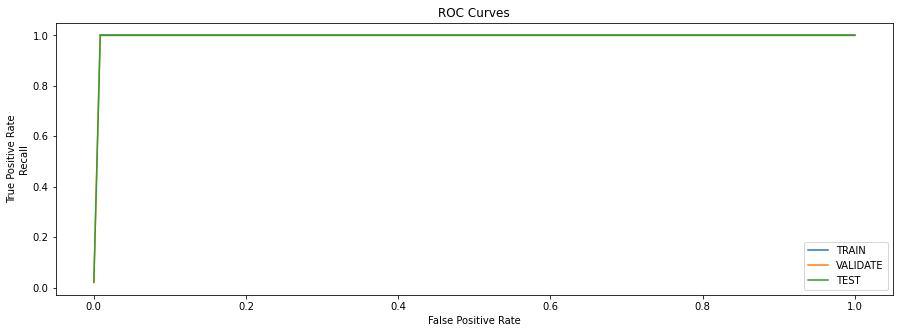

In [35]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Serving With Vertex AI

This demonstration shows the process of exporting and registering a BQML model with Vertex AI Model Registry.  To directly integrate BQML with Vertex AI Model Registry it is now (April 1, 2022) possible at model creation time with options `vertex_ai_model_id` and `vertex_ai_model_version_alises`. See the documentation for this direct integration [here](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Export the BigQuery Model

Reference: [Export the BigQuery Model](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [38]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = '{URI}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [39]:
(export.ended - export.started).total_seconds()

2.612

In [40]:
listing = !gsutil ls {URI}/models/{TIMESTAMP}/model
listing

['gs://statmike-mlops-349915/bqml/automl/models/20230205121239/model/saved_model.pb',
 'gs://statmike-mlops-349915/bqml/automl/models/20230205121239/model/assets/',
 'gs://statmike-mlops-349915/bqml/automl/models/20230205121239/model/variables/']

In [41]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{URI.split('//')[-1]}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915/bqml/automl/models/20230205121239/model?project=statmike-mlops-349915


### Upload The Model To Vertex AI Model Registry

References:
- [aiplatform.Model](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [57]:
modelmatch = aiplatform.Model.list(filter = f'display_name={SERIES}_{EXPERIMENT} AND labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model =  modelmatch[0].resource_name
else:
    print('This is a new model, adding to model registry as version 1')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{SERIES}_{EXPERIMENT}',
        model_id = f'model_{SERIES}_{EXPERIMENT}',
        parent_model = parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/models/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'timestamp': f'{TIMESTAMP}', 'run_name' : f'{RUN_NAME}', 'framework' : f'{framework.lower()}'}
    )  

This is a new model, adding to model registry as version 1
Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_bqml_automl/operations/1881953582756921344
Model created. Resource name: projects/1026793852137/locations/us-central1/models/model_bqml_automl@1
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/model_bqml_automl@1')


In [58]:
model.display_name

'bqml_automl'

In [59]:
model.resource_name

'projects/1026793852137/locations/us-central1/models/model_bqml_automl'

In [60]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/model_{SERIES}_{EXPERIMENT}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_bqml_automl?project=statmike-mlops-349915


---
---
# WORK IN PROGRESS, BELOW THIS POINT IS NOT READY
---
---

---
## Online Predictions with Vertex AI Endpoints

### Create/Retrieve An Endpoint
References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [61]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/6060072685696712704/operations/1512658413312540672
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/6060072685696712704
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/6060072685696712704')
Endpoint Created: projects/1026793852137/locations/us-central1/endpoints/6060072685696712704
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/6060072685696712704?project=statmike-mlops-349915


In [62]:
endpoint.display_name

'bqml'

In [63]:
endpoint.traffic_split

{}

In [64]:
deployed_models = endpoint.list_models()
#deployed_models

### Deploy Model To Endpoint

In [65]:
if (model.display_name, model.version_id) not in [(deployed_model.display_name, deployed_model.model_version_id) for deployed_model in endpoint.list_models()]:
    print(f'Deploying model with 100% of traffic...')
    endpoint.deploy(
        model = model,
        deployed_model_display_name = model.display_name,
        traffic_percentage = 100,
        machine_type = DEPLOY_COMPUTE,
        min_replica_count = 1,
        max_replica_count = 1
    )
else: 
    print(f'The current model/version is already deployed.')

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/us-central1/models/model_bqml_automl to Endpoint : projects/1026793852137/locations/us-central1/endpoints/6060072685696712704
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/6060072685696712704/operations/8460305263461662720


FailedPrecondition: 400 Model server terminated: model server container terminated: exit_code: 	 255
reason: "Error"
started_at {
  seconds: 1675647612
}
finished_at {
  seconds: 1675647614
}
. Model server logs can be found at https://console.cloud.google.com/logs/viewer?project=1026793852137&resource=aiplatform.googleapis.com%252FEndpoint&advancedFilter=resource.type%3D%22aiplatform.googleapis.com%2FEndpoint%22%0Aresource.labels.endpoint_id%3D%226060072685696712704%22%0Aresource.labels.location%3D%22us-central1%22.

### Remove Deployed Models without Traffic

In [ ]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

In [ ]:
endpoint.traffic_split

In [ ]:
#endpoint.list_models()

---
## Prediction

### Retrieve Records For Prediction

In [ ]:
n = 10
pred = bq.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} WHERE splits='TEST' LIMIT {n}").to_dataframe()

In [ ]:
pred.head()

Shape as instances: dictionaries of key:value pairs for only features used in model

In [ ]:
newobs = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET,'splits'])]].to_dict(orient='records')
#newobs[0]

In [ ]:
len(newobs)

In [ ]:
newobs[0]

### Get The Model Signature Name (if TensorFlow)

In [ ]:
if model.labels['framework'] == 'tensorflow':
    import tensorflow as tf
    reloaded_model = tf.saved_model.load(model.uri)
    print(list(reloaded_model.signatures.keys())[0])

### Get The Feature Order (if XGBoost)

In [ ]:
if model.labels['framework'] == 'xgboost':
    import gcsfs
    import tensorflow as tf
    file = f'{model.uri}/assets/model_metadata.json'
    if tf.io.gfile.exists(file):
        gcs = gcsfs.GCSFileSystem(project = PROJECT_ID)
        with gcs.open(file) as fp:
            features = json.load(fp)['feature_names']
    else:
        features = list(newobs[0].keys())

### Prepare Instance For Prediction

Depending on which framework the model is trained with the instance format may be different.  More information can be found [here](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#request-body-details).

Instances:

In [ ]:
if model.labels['framework'] == 'tensorflow':
    instances = {"instances": [newob for newob in newobs[0:1]], "signature_name": list(reloaded_model.signatures.keys())[0]}
elif model.labels['framework'] == 'xgboost':
    instances = {"instances": [[newob[f] for f in features] for newob in newobs[0:1]]}
    
http_body = httpbody_pb2.HttpBody(
    data = json.dumps(instances).encode("utf-8"),
    content_type = "application/json"
)

In [ ]:
print(instances)

### Get Predictions: Python Client

Using Raw Prediction here. This is methods of export from BigQuery have different model signatures and raw prediction client for Vertex AI allow the signature to be include in the request.

Reference:
- [aiplatform.gapic.PredictionSerivceClient.raw_predict()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_raw_predict)

Client:

In [69]:
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
predictor = aiplatform.gapic.PredictionServiceClient(client_options = client_options)

Prediction:

In [70]:
prediction = predictor.raw_predict(
    endpoint = endpoint.resource_name,
    http_body = http_body
)
prediction

content_type: "application/json"
data: "{\n    \"predictions\": [\n        {\n            \"predicted_Class\": [\"0\"],\n            \"Class_probs\": [0.23520476382469077, 0.7647952361753092],\n            \"Class_values\": [\"1\", \"0\"]\n        }\n    ]\n}"

Format raw prediction response using JSON:

In [71]:
prediction = json.loads(prediction.data)
prediction

{'predictions': [{'predicted_Class': ['0'],
   'Class_probs': [0.23520476382469077, 0.7647952361753092],
   'Class_values': ['1', '0']}]}

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:rawPredict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_raw_predict)

Prepare request:

In [72]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps(instances))

Prediction:

In [73]:
prediction = !curl -s POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:rawPredict

prediction

['{',
 '    "predictions": [',
 '        {',
 '            "Class_values": ["1", "0"],',
 '            "predicted_Class": ["0"],',
 '            "Class_probs": [0.23520476382469077, 0.7647952361753092]',
 '        }',
 '    ]',
 '}']

Format raw prediction response using JSON:

In [74]:
prediction = json.loads(''.join([p.strip() for p in prediction]))
prediction

{'predictions': [{'Class_values': ['1', '0'],
   'predicted_Class': ['0'],
   'Class_probs': [0.23520476382469077, 0.7647952361753092]}]}

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints raw-predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/raw-predict)

Prepare request:

In [75]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps(instances))

Prediction:

In [76]:
prediction = !gcloud ai endpoints raw-predict \
{endpoint.name.rsplit('/',1)[-1]} \
--region={REGION} --format="json" --request=@{DIR}/request.json

prediction

['Using endpoint [https://us-central1-aiplatform.googleapis.com/]',
 '{',
 '  "predictions": [',
 '    {',
 '      "Class_probs": [',
 '        0.23520476382469077,',
 '        0.7647952361753092',
 '      ],',
 '      "Class_values": [',
 '        "1",',
 '        "0"',
 '      ],',
 '      "predicted_Class": [',
 '        "0"',
 '      ]',
 '    }',
 '  ]',
 '}']

Format raw prediction response using JSON:

In [77]:
prediction = json.loads("".join(prediction[1:]))
prediction

{'predictions': [{'Class_probs': [0.23520476382469077, 0.7647952361753092],
   'Class_values': ['1', '0'],
   'predicted_Class': ['0']}]}

---
## Remove Resources
see notebook "99 - Cleanup"